# Control Theory

This notebook explore the dynamics and control of the cruise control system of a vehicle.

## Cruise Control System

The Cruise Control is a system that automatically controls the speed of a motor vehicle.

## Dynamics

While this does not intend to be a comprehensive vehicle dynamics model, we can use a simplified model to simulate the behavior of a vehicle. The vehicle produces a force that propels it forward.
This force, $F$, represents the throttle force and is limited by the engine power.

According to Newton's second law:

$$P = F \ v$$

where:
- $P \ $ is the power [watts]
- $F \ $ is the force [N]
- $v \ $ is the velocity  [m/s]

With this, we can estimate the $F_{max}$ for a vehicle will be its engine power divided by its maximum speed.

$$F = \frac{P}{v}$$

> Those values can be found in the vehicle's specifications.


This law also states that the acceleration of an object is directly proportional to the net force acting on it and inversely proportional to its mass. The law is given by the equation:

$$F = m \ a$$

For our vehicle model, the net force is the sum of the throttle force and the disturbance forces:

$$F_{net} = F - F_{d}$$

Then, the acceleration is given by:

$$a = \frac{F_{net}}{m}$$

### Disturbance Forces

We will take into account three major forces that act against the vehicle's motion. The sum of these forces will the disturbance force, $F_{d}$.

$$F_{d} = F_{g} + F_{r} + F_{a}$$

#### Gravity

The force of gravity is given by:

$$F_{g} = m \ g \ sin(\theta)$$

where:
- $m$ is the mass of the vehicle
- $g$ is the acceleration due to gravity
- $\theta$ is the elevation angle of the road

#### Rolling Friction

Rolling friction is the force that opposes the motion of the vehicle. It is given by: 

$$F_{r} = \mu \ N$$

where:
- $\mu$ is the coefficient of rolling friction
- $N$ is the normal force

#### Aerodynamic Drag Force

Drag depends on the properties of the fluid and on the size, shape, and speed of the object. One way to express this is by means of the drag equation:

$$F_{a} =  \frac{1}{2} \ c_{d} \ A  \ \rho \ v^2$$

where:
- $F_{d}$ is the drag force
- $\rho$ is the density of the fluid
- $v$ is the speed of the object relative to the fluid
- $A$ is the area of the object facing the fluid
- $c_{d}$ is the drag coefficient - a dimensionless number

> As we will evaluate aerodynamics, the '_fluid_' is the air.
 
At $101.325\ kPa$ (abs) and $15 °C$ ($59 °F$), air has a density of approximately $1.225 kg/m^3$ according to the [International Standard Atmosphere](https://en.wikipedia.org/wiki/International_Standard_Atmosphere) (ISA).

##### Typical Drag Coefficients values

| Object             | Drag Coefficient ($c_{d}$) |
|--------------------|----------------------------|
| Airfoil            | 0.05                       |
| Toyota Camry       | 0.28                       |
| Ford Focus         | 0.32                       |
| Honda Civic        | 0.36                       |
| Ferrari Testarossa | 0.37                       |
| Dodge Ram pickup   | 0.43                       |
| Bicycle            | 0.9                        |

Source: [College Physics, OpenStax](https://openstax.org/books/college-physics/pages/5-2-drag-forces)

In [1]:
from math import copysign, sin

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pydantic import BaseModel

# Constants
air_density = 1.225  # kg/m^3
g = 9.80665  # m/s^2

### Vehicle Model

We can model a simplified vehicle dynamics using a python class.

In [2]:
class Vehicle(BaseModel):
    """
    Vehicle Dynamics Model
    
    Attributes:
        position: current position of the vehicle (m)
        speed: current speed of the vehicle (m/s)
        mass: mass of the vehicle (Kg)
        max_throttle: maximum throttle force (N)
        drag_coefficient: drag coefficient (dimensionless)
        frontal_area: frontal area of the vehicle (m^2)
    """
    position: float = 0  # m
    speed: float = 0  # m/s
    mass: float  # Kg
    max_throttle: float  # N
    drag_coefficient: float  # dimensionless
    frontal_area: float  # m^2

#### Toyota Camry Example

![Toyota Camry](./assets/camry.png)

Toyota Camry XSE 2025 (4T1DAACK2SU017407)

According to the [Toyota](https://www.toyota.com/camry/2025) specifications, this unit drag coefficient ($c_{d}$) is approximately $0.37$ and the frontal area ($A$) is $1.94 m^2$. It weighs $3538 \ lbs$ ($1604 \ kg$) and has a maximum horsepower of $184hp$  ($137209 \ W$), and maximum top speed of $130mph$  ($209.2km/h$ or $58.33 m/s$).

We can estimate the maximum throttle force using the formula:



then

$$F_{throttle} = \frac{P}{v}$$
$$F_{throttle} = \frac{137209 \ watts}{58.33 \ m/s}$$
$$F_{throttle} = 2352 \ N$$



In [3]:
camry = Vehicle(mass=1604, max_throttle=2352, drag_coefficient=0.37, frontal_area=1.94)
print(f"Toyota Camry XSE 2025({camry})")

Toyota Camry XSE 2025(position=0 speed=0 mass=1604.0 max_throttle=2352.0 drag_coefficient=0.37 frontal_area=1.94)


For our process or plant, we will use a simple model that simulates the vehicle dynamics. This model will have a method that updates the vehicle's position and speed based on the throttle input and the time step.

In [4]:
# Sign function
sign = lambda x: copysign(1, x)


def process(vehicle: Vehicle, throttle: float, dt: float, theta: float = 0.0, mu: float = 0.01) -> float:
    """
    Simulate vehicle dynamics updating its position and speed.
    
    Args:
        vehicle: a dynamic model
        throttle: percentage of throttle input
        dt: time step
        theta: inclination angle of the road
        mu: coefficient of rolling friction

    Returns:
        vehicle speed
    """
    m = vehicle.mass  # Kg
    v = vehicle.speed  # m/s
    area = vehicle.frontal_area  # m^2

    # Force generated by the throttle input
    f = throttle * vehicle.max_throttle

    # force Fg = m g sin \theta.
    fg = m * g * sin(theta)

    # A simple model of rolling friction is Fr = m g Cr sgn(v), where Cr is
    # the coefficient of rolling friction and sgn(v) is the sign of v (±1) or
    # zero if v = 0.
    fr = m * g * mu * sign(v)

    # Fa = 1/2 * Cd * A * rho * v^2
    fa = 0.5 * vehicle.drag_coefficient * area * air_density * v ** 2

    # Total disturbance force
    fd = fg + fr + fa

    # a = F/m
    a = (f - fd) / m

    # Update vehicle position and speed
    vehicle.position += v * dt
    vehicle.speed += a * dt

    if vehicle.speed < 0:
        vehicle.speed = 0

    return vehicle.speed

We have built now a simple open-loop model of the vehicle dynamics.

![Open Loop](./assets/open-loop.png)

In [5]:
class Simulation(BaseModel):
    times: list[float] = []
    speeds: list[float] = []
    positions: list[float] = []
    errors: list[float] = []


def simulate(vehicle: Vehicle, total_time: float = 3_600.0, dt: float = 0.1) -> Simulation:
    sim = Simulation()

    # Reset vehicle state
    vehicle.position = 0
    vehicle.speed = 0

    for t in np.arange(0, total_time, dt):
        throttle = 0.75  # %
        speed = process(vehicle, throttle, dt)

        # Store simulation data
        sim.times.append(t)
        sim.speeds.append(speed)
        sim.positions.append(vehicle.position)

    return sim


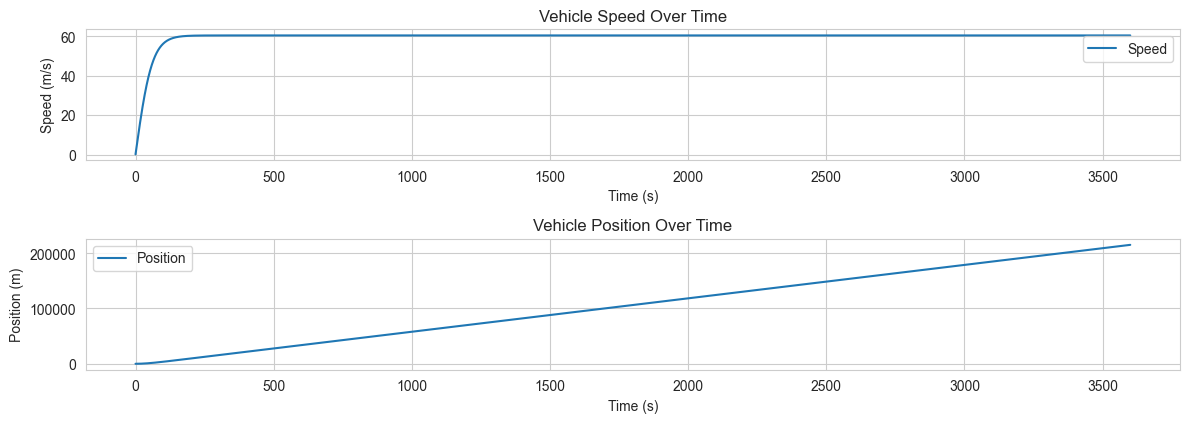

In [6]:
def plot_results(simulation: Simulation, set_speed: float = 0.0):
    plt.clf()
    plt.close()
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(simulation.times, simulation.speeds, label='Speed')
    if set_speed > 0.0:
        plt.axhline(y=set_speed, color='r', linestyle='--', label='Set Speed')
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title('Vehicle Speed Over Time')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(simulation.times, simulation.positions, label='Position')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title('Vehicle Position Over Time')
    plt.legend()

    if len(simulation.errors) > 0:
        plt.subplot(3, 1, 3)
        plt.plot(simulation.times, simulation.errors, label='Error')
        plt.xlabel('Time (s)')
        plt.ylabel('Error (m/s)')
        plt.title('Speed Error Over Time')
        plt.legend()

    plt.tight_layout()
    plt.show()


open_loop = simulate(camry)
plot_results(open_loop)

Nothing surprising here, as no control is applied, the vehicle accelerates until it reaches a maximum speed according to the throttle input and the disturbance forces acting on it.

Let's now implement a simple closed-loop system to control the speed of the vehicle.

![Closed Loop](./assets/closed-loop.png)

Where the controller:

![PID](./assets/pid.png)

In [7]:
class PIDController(BaseModel):
    """
    Proportional-Integral-Derivative Controller
    
    Attributes:
        kp: proportional gain
        ki: integral gain
        kd: derivative gain
    """
    kp: float
    ki: float = 0.0
    kd: float = 0.0

    _integral: float = 0
    _previous_error: float = 0

    def update(self, error: float, dt: float) -> float:
        """
        Update PID controller output
        
        Args:
            error: signal error
            dt: time step
        
        Returns:
            A value between [-1, 1] control signal
        """
        self._integral += error * dt

        derivative = (error - self._previous_error) / dt

        # u(t) = Kp * e(t) + Ki * ∫e(t)dt + Kd * de(t)/dt
        output = self.kp * error + self.ki * self._integral + self.kd * derivative
        self._previous_error = error

        return np.clip(output, -1, 1)

Update the simulation function to include the controller.

In [8]:
from typing import Callable


def simulate(vehicle: Vehicle,
             set_speed: float,
             controller: Callable[[float, float], float],
             total_time: float = 3_600.0,
             dt: float = 0.1) -> Simulation:
    sim = Simulation()

    vehicle.speed = 0
    vehicle.position = 0

    for t in np.arange(0, total_time, dt):
        error = set_speed - vehicle.speed
        throttle = controller(error, dt)  # %
        speed = process(vehicle, throttle, dt)

        # Store simulation data
        sim.times.append(t)
        sim.speeds.append(speed)
        sim.positions.append(vehicle.position)
        sim.errors.append(error)

    return sim

## Comparing Controllers

We will compare the performance of the controllers by setting a desired speed of $30 \ m/s$ (108 km/h) and evaluating the vehicle's response.

In [9]:
def calculate_settling_time(times: list, output: list, percentage: float = 0.05):
    """
    Calculate the settling time from the system output.

    Parameters:
    times (list): Recorded time of the system.
    output (list): System output.
    percentage (float): Tolerance percentage, by default 5%.

    Returns:
    float: settling time
    """
    final_value = output[-1]
    # bounds for 5% tolerance
    lower_bound = final_value * (1 - percentage)
    upper_bound = final_value * (1 + percentage)

    # find the first index where the output is within the bounds
    for i in reversed(range(len(output))):
        if not lower_bound <= output[i] <= upper_bound:
            # the last time the output was outside bounds + one step (we left the bounds)
            return times[i + 1]

    # output was always within the bounds
    return times[0]

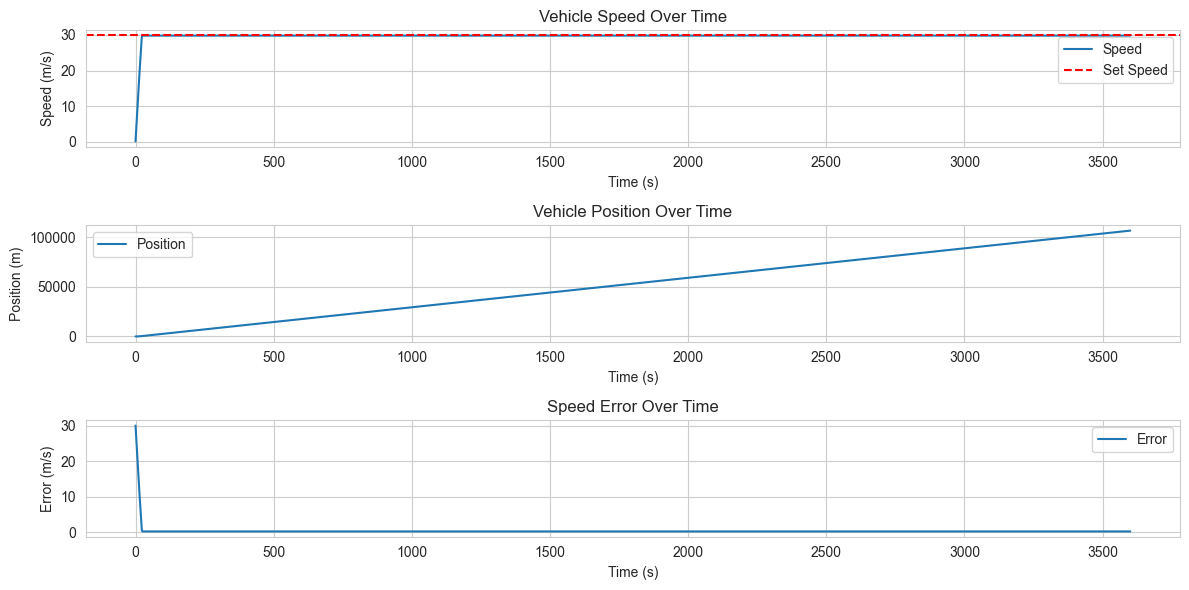

In [10]:
p = PIDController(kp=1)
desired_speed = 30  # m/s (108 km/h)
p_simulation = simulate(camry, set_speed=desired_speed, controller=p.update)
plot_results(p_simulation, set_speed=desired_speed)

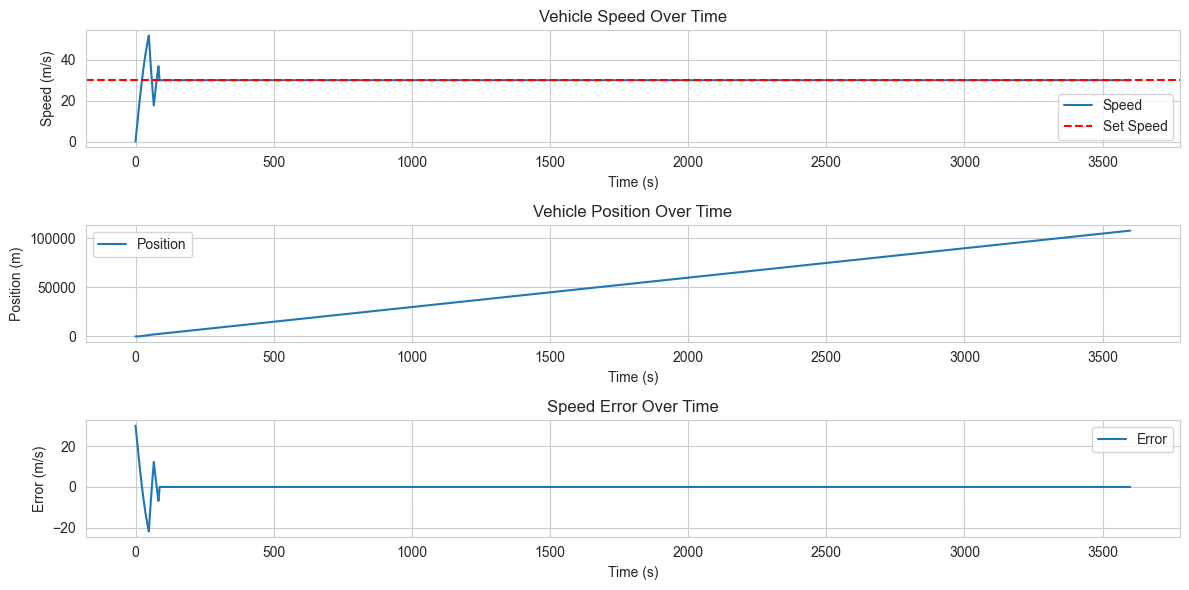

In [11]:
pi = PIDController(kp=1, ki=0.5)
pi_simulation = simulate(camry, set_speed=desired_speed, controller=pi.update)
plot_results(pi_simulation, set_speed=desired_speed)

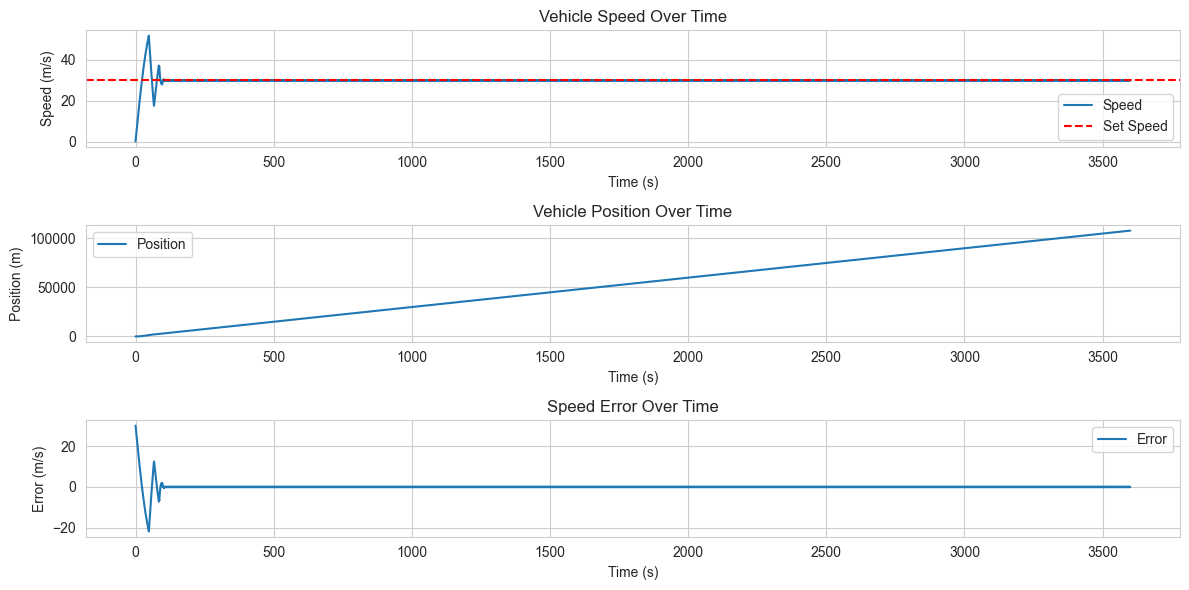

In [12]:
pid = PIDController(kp=1, ki=0.5, kd=2)
pid_simulation = simulate(camry, set_speed=desired_speed, controller=pid.update)
plot_results(pid_simulation, set_speed=desired_speed)

In [13]:
t_p = calculate_settling_time(p_simulation.times, p_simulation.speeds)
t_pi = calculate_settling_time(pi_simulation.times, pi_simulation.speeds)
t_pid = calculate_settling_time(pid_simulation.times, pid_simulation.speeds)
print(f"Settling Time (P): {t_p:.2f} s")
print(f"Settling Time (PI): {t_pi:.2f} s")
print(f"Settling Time (PID): {t_pid:.2f} s")

Settling Time (P): 21.80 s
Settling Time (PI): 86.00 s
Settling Time (PID): 97.00 s


## Disturbance

Let's add a disturbance to the system and evaluate the controllers' performance.

We will simulate a sudden change in the road inclination angle.

In [14]:
from scipy.stats import semicircular


def produce_inclination(prev_theta: float = 0.0,
                        min_theta: float = -5.0,
                        max_theta: float = 20.0,
                        ) -> float:
    # Random change in the inclination angle
    change = semicircular.rvs()

    # Update the inclination angle limiting its value
    theta = round(prev_theta + change, 2)

    return np.clip(theta, min_theta, max_theta)

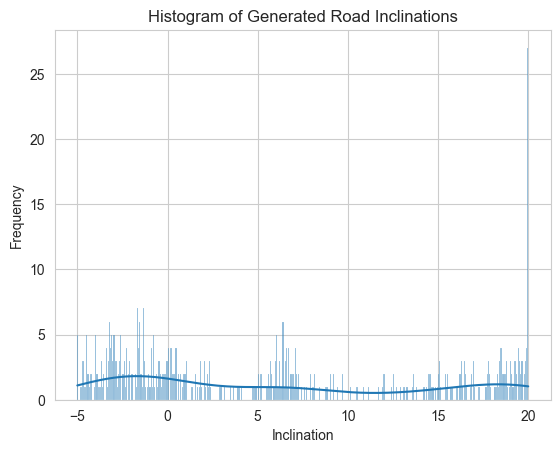

In [15]:
current_theta = 0.0
inclinations = []
for _ in range(500):
    current_theta = produce_inclination(prev_theta=current_theta)
    inclinations.append(current_theta)

# Plotting
sns.histplot(inclinations, bins=400, kde=True)
plt.xlabel('Inclination')
plt.ylabel('Frequency')
plt.title('Histogram of Generated Road Inclinations')
plt.show()

Now, these inclinations change do not happen at regular intervals, so we will update the simulation function to include the disturbance.

We will use [Maxwell distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.maxwell.html#scipy.stats.maxwell) to generate random intervals between disturbances.

$$f(x) = \sqrt{2/\pi} x^2 e^{-x^2/2}$$

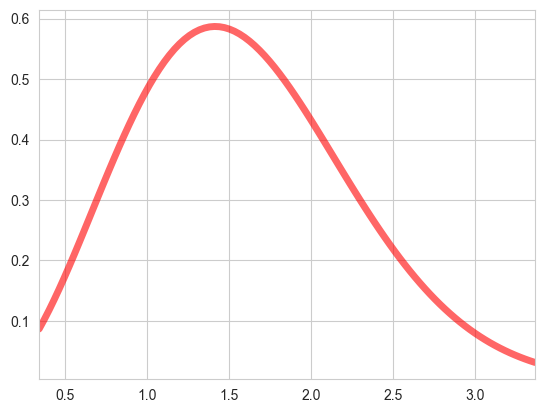

In [16]:
from scipy.stats import maxwell

fig, ax = plt.subplots(1, 1)
rv = maxwell()

x = np.linspace(maxwell.ppf(0.01),
                maxwell.ppf(0.99), 100)
ax.plot(x, maxwell.pdf(x), 'r-', lw=5, alpha=0.6, label='maxwell pdf')
ax.set_xlim([x[0], x[-1]])
plt.show()

In [17]:
def interval_generator() -> list[int]:
    """
    Generate random intervals between disturbances.
    """
    intervals = maxwell.rvs(loc=5, scale=750, size=3_600)
    return list(set(map(int, sorted(intervals))))

Update the simulation function to include the disturbance.

In [18]:
def adjust_inclination(theta: float = 0.0,
                       rate: float = 0.5,
                       ) -> float:
    if theta >= 0:
        return np.clip(theta - rate, 0, theta)
    elif theta < 0:
        return np.clip(theta + rate, theta, 0)


def generate_disturbances() -> dict:
    """
    Generate random disturbances.
    """
    times = interval_generator()
    return {t: produce_inclination() for t in times}


road_inclinations = generate_disturbances()


def simulate_with_disturbance(vehicle: Vehicle,
                              set_speed: float,
                              controller: Callable[[float, float], float],
                              total_time: float = 3_600.0,
                              dt: float = 1.0) -> Simulation:
    sim = Simulation()

    # Set Initial State
    vehicle.speed = 0.0
    vehicle.position = 0.0
    inclination_angle = 0.0
    t_last_disturbance = 0

    for t in np.arange(0, total_time, dt):

        # Check for disturbances
        if int(t) in road_inclinations.keys():
            inclination_angle = road_inclinations[int(t)]
            t_last_disturbance = t
        # Gradual change in the inclination angle after a disturbance to simulate the road leveling
        if t_last_disturbance + 2 > t:
            inclination_angle = adjust_inclination(inclination_angle)

        error = set_speed - vehicle.speed
        throttle = controller(error, dt)  # %
        speed = process(vehicle, throttle, dt, theta=inclination_angle)

        if speed > 70.0:
            print(
                f"SPEED Error at {t}s, speed: {speed} m/s, throttle: {throttle * 100} %, error: {error} m/s, inclination: {inclination_angle}")
            break

        # Store simulation data
        sim.times.append(t)
        sim.speeds.append(speed)
        sim.positions.append(vehicle.position)
        sim.errors.append(error)

    return sim

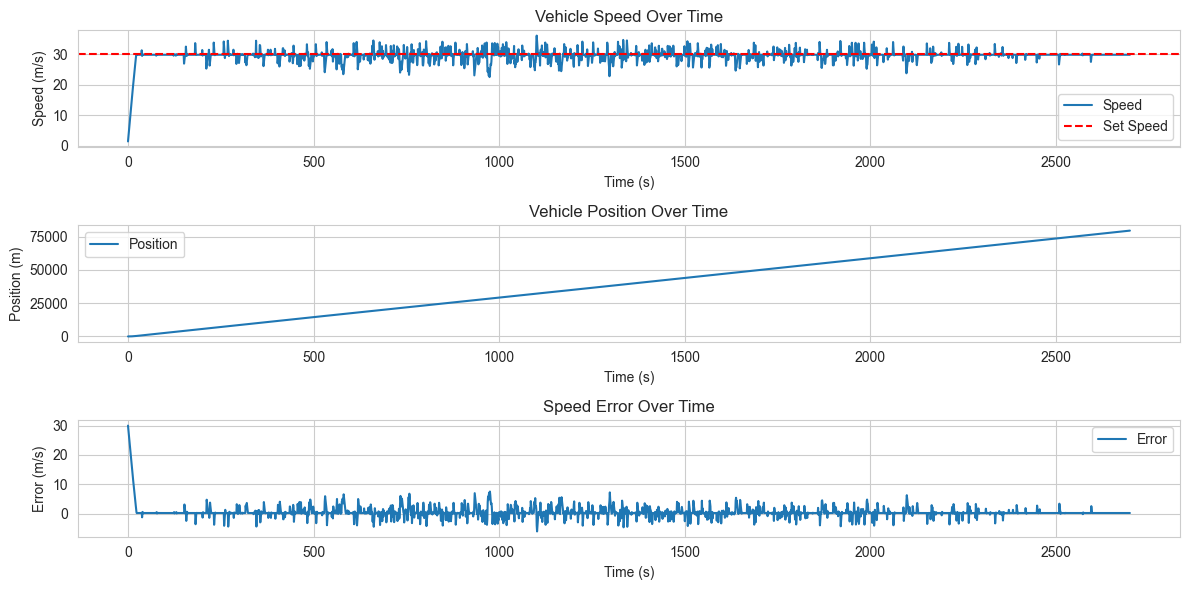

In [19]:
p_simulation = simulate_with_disturbance(camry, set_speed=desired_speed, controller=p.update, total_time=45 * 60)
plot_results(p_simulation, set_speed=desired_speed)

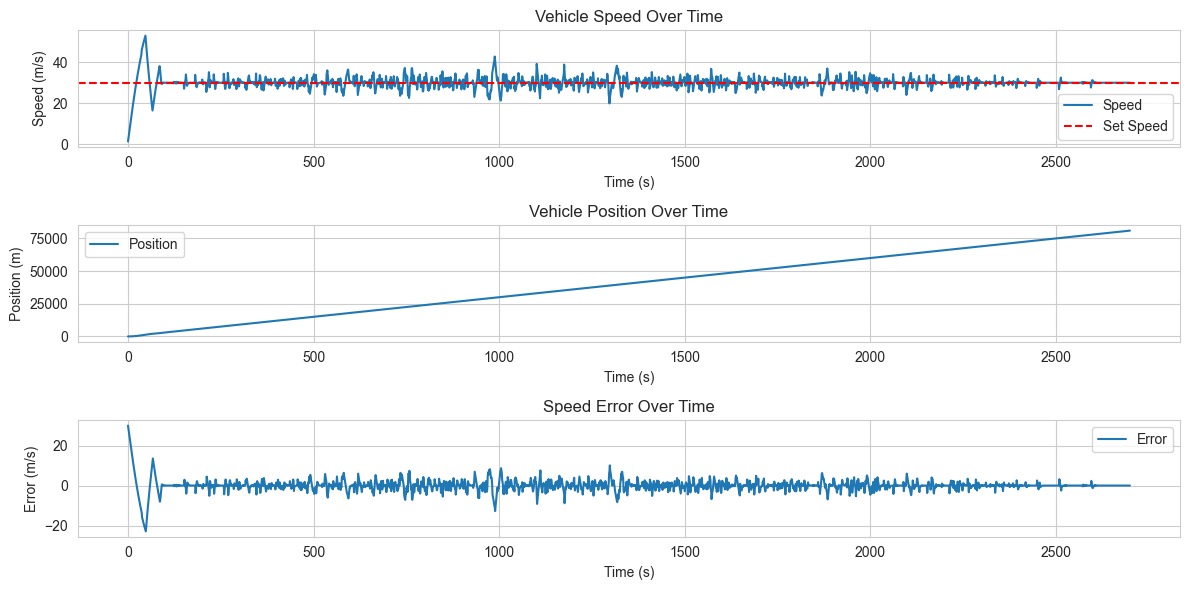

In [20]:
pi_simulation = simulate_with_disturbance(camry, set_speed=desired_speed, controller=pi.update, total_time=45 * 60)
plot_results(pi_simulation, set_speed=desired_speed)

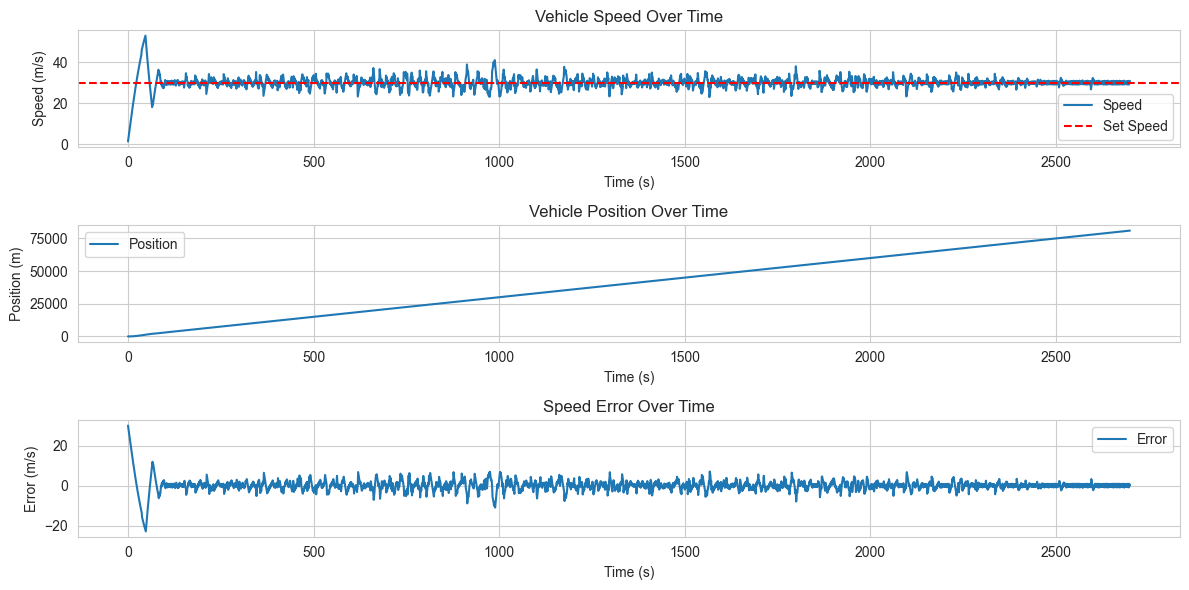

In [21]:
pid_simulation = simulate_with_disturbance(camry, set_speed=desired_speed, controller=pid.update, total_time=45 * 60)
plot_results(pid_simulation, set_speed=desired_speed)

In [22]:
data = {
    "Simulation": ["P", "PI", "PID"],
    "Max Distance (km)": [max(p_simulation.positions) / 1_000, max(pi_simulation.positions) / 1_000,
                          max(pid_simulation.positions) / 1_000],
    "Average Speed": [sum(p_simulation.speeds) / len(p_simulation.speeds),
                      sum(pi_simulation.speeds) / len(pi_simulation.speeds),
                      sum(pid_simulation.speeds) / len(pid_simulation.speeds)],
    "Max Speed": [max(p_simulation.speeds), max(pi_simulation.speeds), max(pid_simulation.speeds)],
    "Min Speed": [min(p_simulation.speeds), min(pi_simulation.speeds), min(pid_simulation.speeds)],
    "Max Error": [max(p_simulation.errors), max(pi_simulation.errors), max(pid_simulation.errors)],
    "Min Error": [min(p_simulation.errors), min(pi_simulation.errors), min(pid_simulation.errors)]
}

pd.DataFrame(data)

,Simulation,Max Distance (km),Average Speed,Max Speed,Min Speed,Max Error,Min Error
0,P,79.577398,29.484135,36.044698,1.368268,30.0,-6.044698
1,PI,81.000000,30.011111,52.967966,1.368268,30.0,-22.967966
2,PID,80.998454,30.010876,52.967966,1.368268,30.0,-22.967966
